In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Downloading Data, Importing Packages, and Generating Images

In [ ]:
# Colab library to upload files to notebook
from google.colab import files
# Install Kaggle Library
!pip install -q kaggle

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle (2).json


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d moltean/fruits

fruits.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q fruits.zip

replace fruits-360/LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace fruits-360/Test/Apple Braeburn/321_100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import backend, models, layers, optimizers, regularizers, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from IPython.display import display
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation # We add the Concatentate function
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, BatchNormalization # We will use AveragePooling2D. Similar to MaxPooling but now we take the average value in the window.

np.random.seed(25)

In [ ]:
base_dir = '/content/fruits-360'
training = (base_dir + '/Training')
test = (base_dir + '/Test')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.30) # set validation split
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    training,
    target_size=(100, 100),
    batch_size=20,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    training, # same directory as training data
    target_size=(100,100),
    batch_size=20,
    class_mode='categorical',
    subset='validation') # set as validation data

test_generator = test_datagen.flow_from_directory(
    test,
    target_size=(100, 100),
    batch_size=20,
    class_mode='categorical')                                   

Found 47427 images belonging to 131 classes.
Found 20264 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


## Show/plot sample images with labels


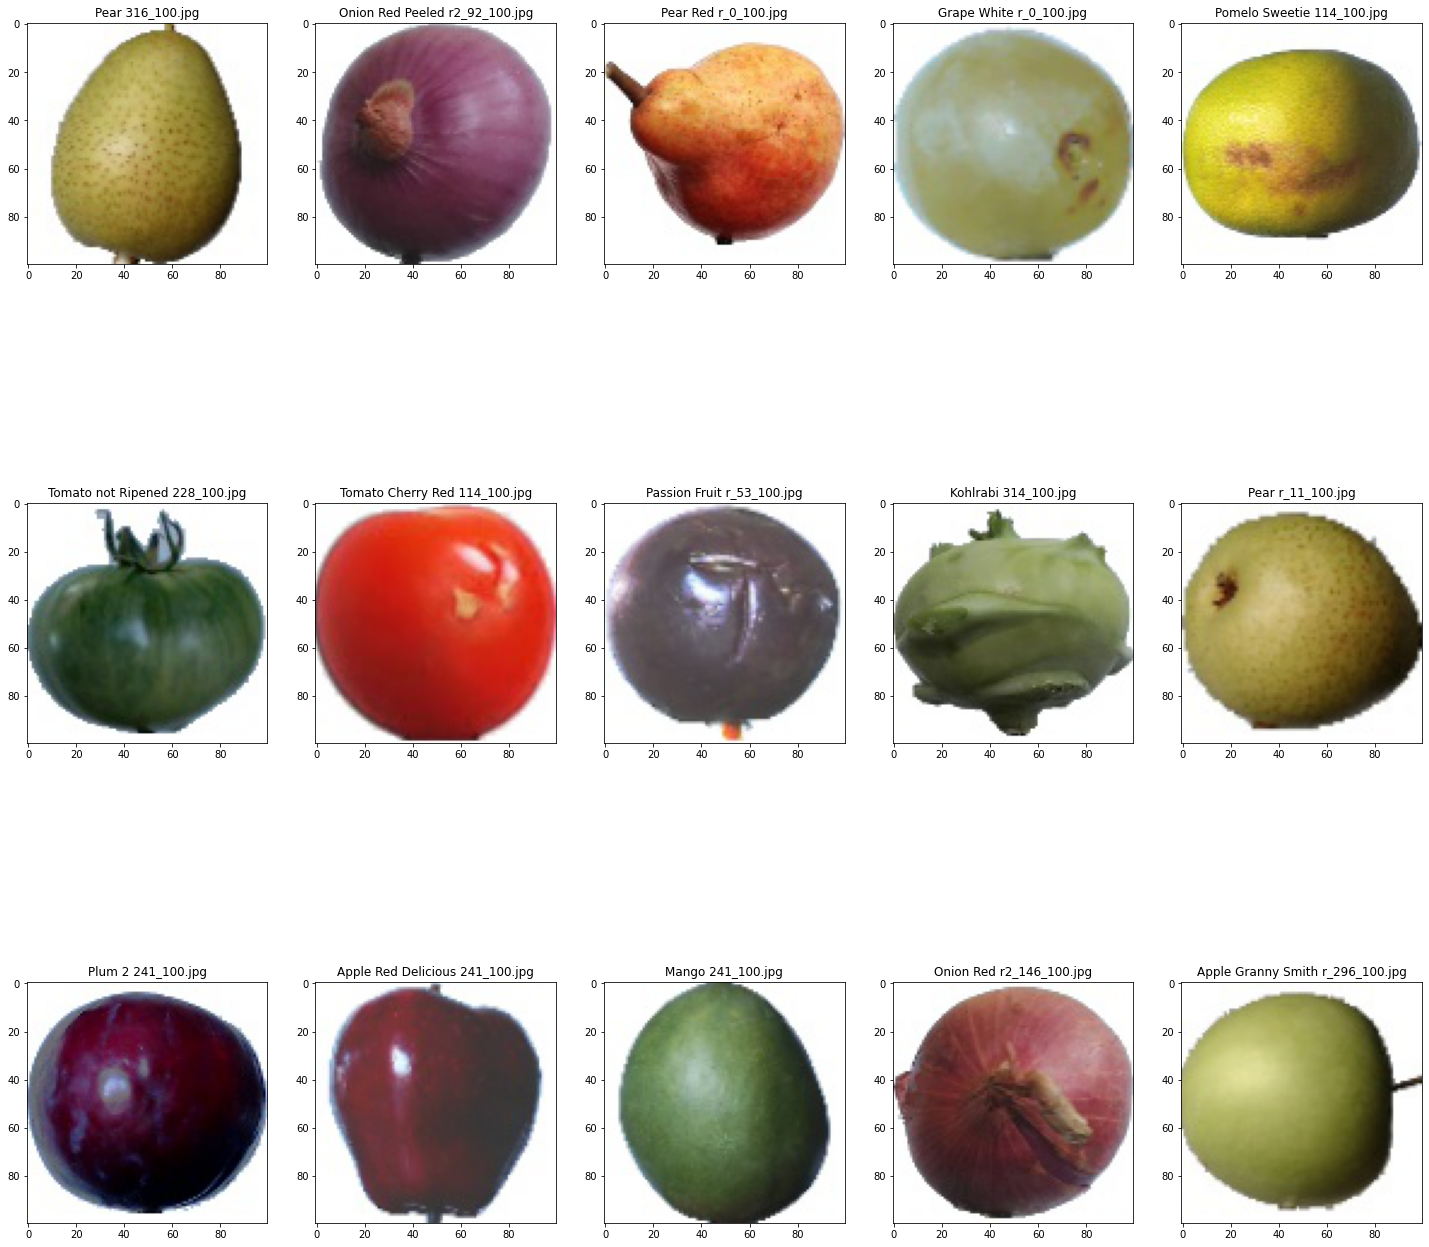

In [ ]:
# Get list of directory names corresponding to fruits
directory_list = []
for directory in os.listdir(test):
    directory_list.append(directory)

# View a few of the images, randomly
plt.figure(figsize=(25,25))
for i in range(15):
    random_int = random.randint(0, len(directory_list)-1)

    file = os.listdir(training + '/' + str(directory_list[random_int]))[i]
    image_loc= os.path.join(training + '/' + str(directory_list[random_int]), file)

    img = mpimg.imread(image_loc)

    grid = plt.subplot(3, 5, i + 1)
    grid.title.set_text(str(directory_list[random_int] + ' ' + str(file)))
    plt.imshow(img)

# Creating and Analyzing the Base Model

### Creating the Base Model
- including: Convolution, Max Pooling, and Batch Normalization
- Using the functional API

### Training the model
- Using Validation Data

### Plots of Accuracy/loss vs epochs

### Evaluating the Model on Test Data

### Result: 84.10% Accuracy

Epoch 1/50
100/100 [==============================] - 69s 690ms/step - loss: 4.8521 - accuracy: 0.0245 - val_loss: 5.1266 - val_accuracy: 0.0074
Epoch 2/50
100/100 [==============================] - 68s 688ms/step - loss: 4.5855 - accuracy: 0.0555 - val_loss: 6.2143 - val_accuracy: 0.0126
Epoch 3/50
100/100 [==============================] - 68s 687ms/step - loss: 4.2099 - accuracy: 0.0970 - val_loss: 5.4694 - val_accuracy: 0.0145
Epoch 4/50
100/100 [==============================] - 71s 713ms/step - loss: 3.8390 - accuracy: 0.1330 - val_loss: 3.9062 - val_accuracy: 0.1102
Epoch 5/50
100/100 [==============================] - 69s 695ms/step - loss: 3.3516 - accuracy: 0.1920 - val_loss: 2.9585 - val_accuracy: 0.2575
Epoch 6/50
100/100 [==============================] - 69s 695ms/step - loss: 3.1053 - accuracy: 0.2365 - val_loss: 2.9596 - val_accuracy: 0.2325
Epoch 7/50
100/100 [==============================] - 70s 700ms/step - loss: 2.8399 - accuracy: 0.2990 - val_loss: 2.2748 - val_ac

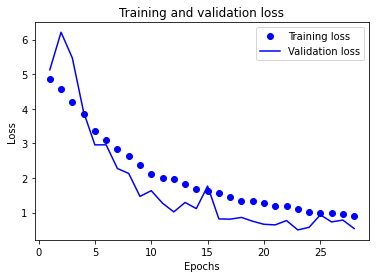

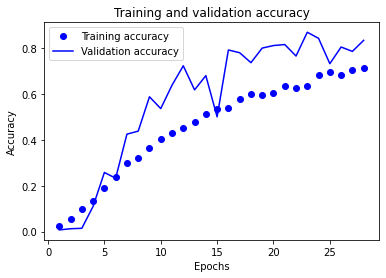

50/50 [==============================] - 3s 59ms/step - loss: 0.4974 - accuracy: 0.8410
test_acc: 0.8410000205039978


In [ ]:
backend.clear_session()

# Input model
visible = Input(shape=(100,100,3))

conv1 = Conv2D(32, (3,3), activation = 'relu')(visible)
maxpool1 = MaxPooling2D(pool_size=(2,2))(conv1)
batchnorm1 = BatchNormalization()(maxpool1)

conv2 = Conv2D(32, (3,3),  padding='same', activation = 'relu')(batchnorm1)
maxpool2 = MaxPooling2D(pool_size=(2,2))(conv2)
batchnorm2 = BatchNormalization()(maxpool2)

conv3 = Conv2D(32, (3,3),  padding='same', activation = 'relu')(batchnorm2)
maxpool3 = MaxPooling2D(pool_size=(2,2))(conv3)
batchnorm3 = BatchNormalization()(maxpool3)

flatten = Flatten()(batchnorm3)
dense1 = Dense(64, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)

output = Dense(131, activation='softmax')(dropout1)

model = Model(inputs=visible, outputs=output)

model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

history = model.fit(
    train_generator, 
    epochs=50, 
    steps_per_epoch=100,
    batch_size = 20,
    validation_data=validation_generator, 
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)])

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_generator, steps = 50) 
print('test_acc:', test_acc)

## Data Augmentation

In [ ]:
datagen = ImageDataGenerator( # The image augmentaion function in Keras
    rotation_range=40, # Rotate the images randomly by 40 degrees
    width_shift_range=0.2, # Shift the image horizontally by 20%
    height_shift_range=0.2, # Shift the image veritcally by 20%
    shear_range=0.2, # Shear image by 20%
    zoom_range=0.2, # Zoom in on image by 20%
    horizontal_flip=True, # Flip image horizontally 
    fill_mode='nearest') # How to fill missing pixels after a augmentaion opperation

# Apply the data augmentation to our data.
train_datagen2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = 'nearest',
    validation_split=0.30)

test_datagen2 = ImageDataGenerator(rescale=1./255) #Never apply data augmentation to test data.  You only want to normalize and resize test data. 

train_generator2 = train_datagen2.flow_from_directory(
    training,
    target_size=(100, 100),
    batch_size=20,
    class_mode='categorical',
    subset='training')

validation_generator2 = train_datagen2.flow_from_directory(
    training,
    target_size=(100, 100),
    batch_size=20,
    class_mode='categorical',
    subset='validation')

test_generator2 = test_datagen2.flow_from_directory( # Resize test data
    test,
    target_size=(100, 100),
    batch_size=20,
    class_mode='categorical')

Found 47427 images belonging to 131 classes.
Found 20264 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


## Training the Base Model Using Data Augmentation

### Result: 90.50%

Epoch 1/50
300/300 [==============================] - 148s 491ms/step - loss: 4.7673 - accuracy: 0.0330 - val_loss: 5.2158 - val_accuracy: 0.0250
Epoch 2/50
300/300 [==============================] - 147s 492ms/step - loss: 4.4196 - accuracy: 0.0647 - val_loss: 4.2157 - val_accuracy: 0.0711
Epoch 3/50
300/300 [==============================] - 147s 492ms/step - loss: 4.0930 - accuracy: 0.0773 - val_loss: 4.6092 - val_accuracy: 0.0909
Epoch 4/50
300/300 [==============================] - 148s 493ms/step - loss: 3.8044 - accuracy: 0.1080 - val_loss: 4.0564 - val_accuracy: 0.1183
Epoch 5/50
300/300 [==============================] - 147s 492ms/step - loss: 3.5307 - accuracy: 0.1365 - val_loss: 2.7623 - val_accuracy: 0.2385
Epoch 6/50
300/300 [==============================] - 147s 491ms/step - loss: 3.3180 - accuracy: 0.1595 - val_loss: 3.0010 - val_accuracy: 0.2327
Epoch 7/50
300/300 [==============================] - 147s 491ms/step - loss: 3.1186 - accuracy: 0.1851 - val_loss: 2.3279 -

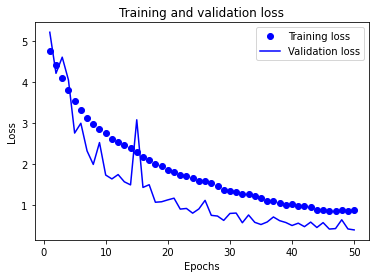

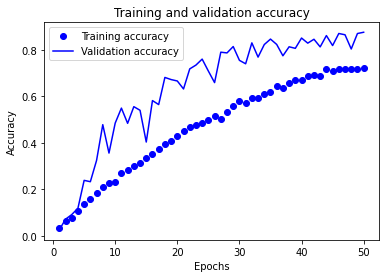

50/50 [==============================] - 3s 60ms/step - loss: 0.2906 - accuracy: 0.9050
test_acc: 0.9049999713897705


In [ ]:
backend.clear_session()

# Input model
visible = Input(shape=(100,100,3))

conv1 = Conv2D(32, (3,3), activation = 'relu')(visible)
maxpool1 = MaxPooling2D(pool_size=(2,2))(conv1)
batchnorm1 = BatchNormalization()(maxpool1)

conv2 = Conv2D(32, (3,3),  padding='same', activation = 'relu')(batchnorm1)
maxpool2 = MaxPooling2D(pool_size=(2,2))(conv2)
batchnorm2 = BatchNormalization()(maxpool2)

conv3 = Conv2D(32, (3,3),  padding='same', activation = 'relu')(batchnorm2)
maxpool3 = MaxPooling2D(pool_size=(2,2))(conv3)
batchnorm3 = BatchNormalization()(maxpool3)

flatten = Flatten()(batchnorm3)
dense1 = Dense(64, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)

output = Dense(131, activation='softmax')(dropout1)

model = Model(inputs=visible, outputs=output)

model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

history = model.fit(
    train_generator2, 
    epochs=50, 
    steps_per_epoch=300,
    batch_size = 20,
    validation_data=validation_generator2, 
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)])

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_generator2, steps = 50) 
print('test_acc:', test_acc)

## Transfer Learning 

Including:
- Transfer Learning (Xception)
- Functional API
- Data Augmentation
- Unfreezing only the last 6 layers, which represent the last tier of convolution layers.

Accuracy: 89.00%

In [ ]:
from tensorflow.keras.applications import Xception

backend.clear_session()
conv_base = Xception (weights = 'imagenet',  
                  include_top = False,
                  input_shape = (100, 100, 3))

for layer in conv_base.layers[:-6]:
  layer.trainable = False

x = conv_base.output

flatten = Flatten()(x)
dense1 = Dense(512, activation='relu')(flatten)
output = Dense(131, activation='softmax')(dense1)

model = Model(inputs=conv_base.input, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

Epoch 1/25
300/300 [==============================] - 82s 268ms/step - loss: 2.0531 - accuracy: 0.5212 - val_loss: 1.7505 - val_accuracy: 0.5995
Epoch 2/25
300/300 [==============================] - 79s 265ms/step - loss: 0.8260 - accuracy: 0.7650 - val_loss: 0.8798 - val_accuracy: 0.7552
Epoch 3/25
300/300 [==============================] - 80s 268ms/step - loss: 0.5713 - accuracy: 0.8342 - val_loss: 0.9010 - val_accuracy: 0.7744
Epoch 4/25
300/300 [==============================] - 81s 270ms/step - loss: 0.4307 - accuracy: 0.8764 - val_loss: 0.6096 - val_accuracy: 0.8222
Epoch 5/25
300/300 [==============================] - 80s 267ms/step - loss: 0.4039 - accuracy: 0.8831 - val_loss: 0.6812 - val_accuracy: 0.8173
Epoch 6/25
300/300 [==============================] - 80s 267ms/step - loss: 0.3351 - accuracy: 0.9048 - val_loss: 0.8189 - val_accuracy: 0.8218
Epoch 7/25
300/300 [==============================] - 80s 268ms/step - loss: 0.3162 - accuracy: 0.9088 - val_loss: 0.4443 - val_ac

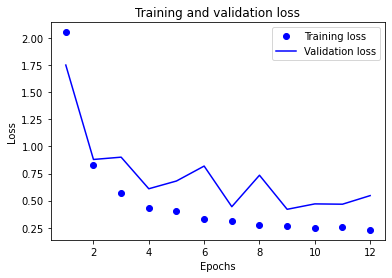

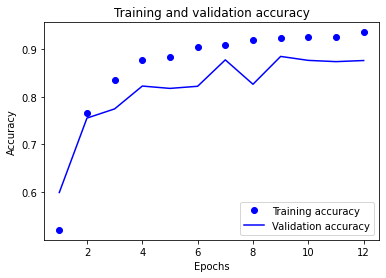

50/50 [==============================] - 1s 25ms/step - loss: 0.4326 - accuracy: 0.8900
test_acc: 0.8899999856948853


In [ ]:
from tensorflow.keras.applications import Xception

backend.clear_session()
conv_base = Xception (weights = 'imagenet',  
                  include_top = False,
                  input_shape = (100, 100, 3))

for layer in conv_base.layers[:-6]:
  layer.trainable = False

x = conv_base.output

flatten = Flatten()(x)
dense1 = Dense(512, activation='relu')(flatten)
output = Dense(131, activation='softmax')(dense1)

model = Model(inputs=conv_base.input, outputs=output)

model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

history = model.fit(
    train_generator2, 
    epochs=25, 
    steps_per_epoch=300,
    batch_size = 50,
    validation_data=validation_generator2, 
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)])

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_generator2, steps = 50) 
print('test_acc:', test_acc)

## Combining Base Model and Transfer Learning

### Here is my best model, which contains:

- A mix of the Base Model and Using Transfer Learning
- Unfreezing the last 15 layers of the Xception model, which corresponds to a few tiers of convolution layers
- Using sequential API to add on a section of the base model, which uses a convoluation layer, a max pooling layer, and batch normalization.

### Result: 94.60% Accuracy on the first evaluation, I saw as high as 96.29% later

Epoch 1/50
300/300 [==============================] - 117s 276ms/step - loss: 4.0204 - accuracy: 0.1453 - val_loss: 2.6905 - val_accuracy: 0.3420
Epoch 2/50
300/300 [==============================] - 76s 255ms/step - loss: 2.2553 - accuracy: 0.4171 - val_loss: 1.3379 - val_accuracy: 0.6365
Epoch 3/50
300/300 [==============================] - 75s 249ms/step - loss: 1.4618 - accuracy: 0.6023 - val_loss: 0.8517 - val_accuracy: 0.7542
Epoch 4/50
300/300 [==============================] - 74s 247ms/step - loss: 1.0063 - accuracy: 0.7190 - val_loss: 1.1418 - val_accuracy: 0.7245
Epoch 5/50
300/300 [==============================] - 74s 247ms/step - loss: 0.8599 - accuracy: 0.7560 - val_loss: 0.6501 - val_accuracy: 0.8098
Epoch 6/50
300/300 [==============================] - 74s 247ms/step - loss: 0.6468 - accuracy: 0.8137 - val_loss: 0.5827 - val_accuracy: 0.8447
Epoch 7/50
300/300 [==============================] - 73s 244ms/step - loss: 0.5619 - accuracy: 0.8418 - val_loss: 0.5889 - val_a

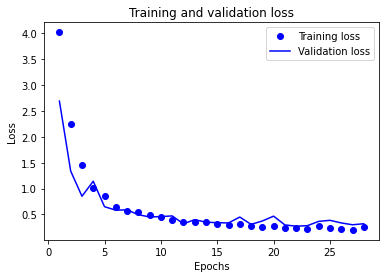

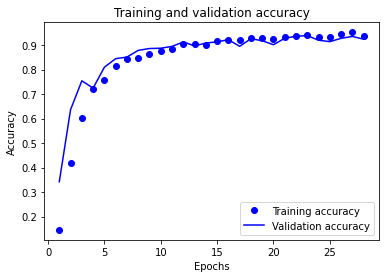

50/50 [==============================] - 1s 24ms/step - loss: 0.2829 - accuracy: 0.9460
test_acc: 0.9459999799728394


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
from tensorflow.keras.applications import Xception

backend.clear_session()
conv_base = Xception (weights = 'imagenet',  
                  include_top = False,
                  input_shape = (100, 100, 3))

for layer in conv_base.layers[:-15]:
  layer.trainable = False

x = conv_base.output

###################################################################
conv1 = Conv2D(256, (3,3), padding='same',activation = 'relu')(x)
maxpool1 = MaxPooling2D(pool_size=(2,2),padding='same')(conv1)
batchnorm1 = BatchNormalization()(maxpool1)

flatten = Flatten()(batchnorm1)
dense1 = Dense(256, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)

output = Dense(131, activation='softmax')(dropout1)
####################################################################

model4 = Model(inputs=conv_base.input, outputs=output)

model4.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

history = model4.fit(
    train_generator2, 
    epochs=50, 
    steps_per_epoch=300,
    batch_size = 50,
    validation_data=validation_generator2, 
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)])

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model4.evaluate(test_generator2, steps = 50) 
print('test_acc:', test_acc)

model4.save('fruit_transfer_base.h5')

## Show/plot sample incorrect images with labels

In [ ]:
# Load the model
from tensorflow import keras
model = keras.models.load_model('fruit_transfer_base.h5')

In [ ]:
test_loss, test_acc = model.evaluate(test_generator2, steps = 50) 
print('test_acc:', test_acc)

50/50 [==============================] - 1s 25ms/step - loss: 0.2082 - accuracy: 0.9630
test_acc: 0.9629999995231628


Found 22688 images belonging to 131 classes.


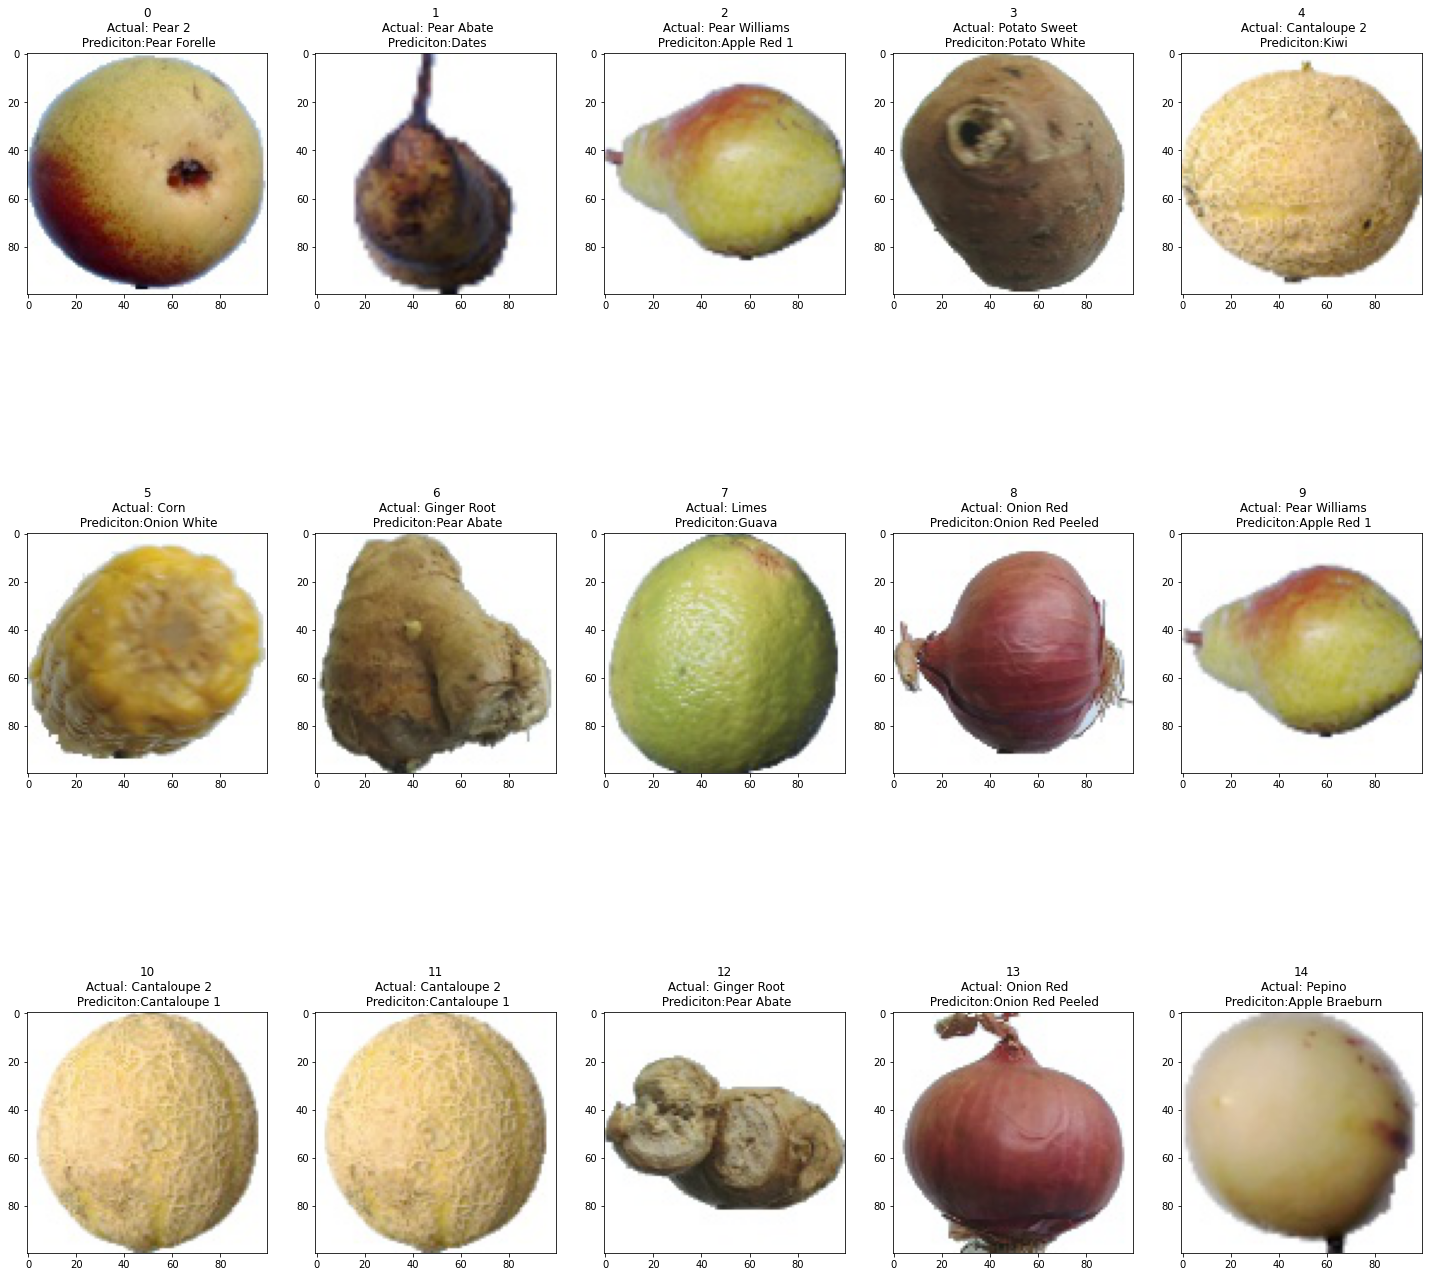

In [ ]:
# Generate test data again without shuffling
test_generator = test_datagen.flow_from_directory(
    test,
    target_size=(100, 100),
    batch_size=20,
    class_mode='categorical',
    shuffle=False)

# Use the model to get predictions
predictions = model.predict(test_generator)

# Get list of predicted labels
Y_pred = numpy.rint(predictions)
y_pred = np.argmax(Y_pred, axis=1)

# Get list of actual labels
y_true = test_generator.classes

# Get list of filenames
fnames = test_generator.filenames

# Compile a list of errors, which is when the true label doesn't match up with the prediction
errors = []

for x in range(len(y_true)):
  if y_true[x] != y_pred[x]:
    errors.append(x)

# View a few of the images, randomly, and display grid with prediction and true label
plt.figure(figsize=(25,25))
for i in range(15):
    random_int = random.randint(0, len(errors)-1)
    image_loc = os.path.join(test + '/' + str(fnames[errors[random_int]]))
    img = mpimg.imread(image_loc)

    grid = plt.subplot(3, 5, i + 1)
    grid.title.set_text(str(i) + '\n' + ' Actual: ' + target_names[y_true[errors[random_int]]] + '\n' + ' Prediciton:' + target_names[y_pred[errors[random_int]]])
    plt.imshow(img)

# Write Up

## Overview of Assignment

This assignment was a culmination of everything we've learned in this course.  The overall goal was to use a Kaggle dataset and build a classfier in the form of a deep neural network.  To accomplish this goal, I used convolution layers, max pooling, batch normalizaiton, Keras' functional API, data augmentation, and transfer learning to construct my model.  I then trained it on validation data and evaluated the model on test data.  After testing, I observed some of the model's incorrect classifications.  My best model achieved a highest result of **96.29%**.

## Description of Data

For this assignment, I chose to classify fruit varieties using the 'Fruits 360' dataset on Kaggle.  This dataset contains 90,483 images of fruits and vegetables.  Of the total, 67,692 images are the training set and 22,688 images are in the test set.  The data doesn't come with validation data, so I separated some out using Keras' ImageDataGenerator.  These images encompass 131 different variets of fruits and vegetables and are 100 x 100 pixels in size each.  

The images were taken by a webcam in front of a white background.  The images contain different angles and rotations of each fruit.  Files are named according to what variety of fruit or vegetable they are, and at what rotation they were placed for the photo.  

##  Summary of Methods

I began the assignment by downloading the dataset from Kaggle and then loading it into Google Colab.  I used ImageDataGenerator() to create the test, train, and validation set.  

Next, I displayed 15 of the test images with labels to confirm that the data loaded correctly as well as to get an idea of what the images of the dataset were like.

Third, I constructed a baseline model.  This model used the functional API to create three tiers of a Conv2D layer, a MaxPooling layer, and a BatchNorm layer.  These tiers were stacked on top of each other.  Then I included a Flatten layer, a Dense layer, and a Dropout layer before the classification layer which had size of 131 for the different classes and used a softmax activation.  Next, I trained the model, plotted the accuracy and loss, and evaluated the model on the test data.  The model achieved an accuracy of 84.10%.

Next, I performed data augmentation using the ImageDataGenerator().  I made several adjustments including ratations, shifts, zooms, cropping, and flips of the image.  

I then trained the baseline model on the augmented data.  With more data, the model achieved an accuracy of 90.50%.

Having this baseline, I then turned to Transfer Learning to try and improve my model even more.  I decided to use the Xception pretrained model on my dataset.  I unfroze the last 6 layers of the model, which represented the last tier of convolution layers.  Training this new model on the augmented data produced an accuracy of 89.00%.

Seeing that the model which used transfer learning had a lower accuracy than the base model, I decided to combine the two methods and see if I could achieve a higher accuracy overall.  I used some of the base model's structure on top of the Xception model (explained more in depth below) and trained it on the augmented data.  This model achieved accuracies between 94.60% and 96.29%.

Finally, I plotted some of the images that the model was predicting incorrectly to see what fruit and vegetable varieties the model was having difficulty identifying.

## Summary of Model

My best model was a mixture of transfer learning using the Xception pre-trained model and my baseline model.  I utilized Xception and unfroze the last 15 layers, which represented the last 3 tiers of convolution layers in the network.  I then added one tier of the baseline model (Conv2d, MaxPooling, BatchNormaliztion) before adding a flatten layer, a dense layer, and the classification output layer for the 131 different types of fruits and vegetables. This model trained for 28 epochs before stopping due to failing to improve on its maximum for 5 epochs (patience=5).  I evaluated the model two times after training, getting accuracies of 94.60% and 96.29%.  This model was an improvement over the baseline and over using transfer learning only.

## Analysis of Results

As stated, my best model produced a highest accuracy of 96.29%.  I was impressed by this model because at the begining of the assignment when I looked at some of the images, many looked very similar.  For example, there are several different varieties of apples in the dataset, many of which I'm not sure I could identify with high accuracy.  But the model does.  

At the end of the assignment, I display 15 of the incorrect predictions.  Some of the mistakes are surprising - classifying corn as white onion - and some are understandable due to lack of scale - classifying cantaloupe as a kiwi.  I only chose a random 15 errors, but I was surprised that the vast majority of the errors were ones that I could have classified correctly.  I did not see errors of confusing differnt types of apples (one error involved pears) but the model classified ginger as pears two times in the 15.  It seemed like the model performed well in some areas I consider nuanced, and poorly in some areas I considered obvious. 

However, it is hard to look down on an accuracy of 96% and I'd guess that with some refinement the model could be improved to closer to 99%.  

Overall this was a really interesting assignment and dataset to analyze.  I was impressed with my model's performance and it was satisfying to apply so many topics here that I have learned throughout the course.